# Change working directory

In [1]:
%cd /kaggle/working
%ls

/kaggle/working
__notebook_source__.ipynb


# Libraries
- cv2: load image and draw rectangle (imread,  cvtColor, rectangle)
- random: shuffle the list (shuffle)
- pandas: create DataFrame
- matplotlib: show images and plot graph
- os: work with file

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os, cv2, random
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Convolution2D,MaxPooling2D, Dense, Flatten, InputLayer
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Unzip files

In [3]:
import zipfile
input_path = '/kaggle/input/dogs-vs-cats'
work_path = '/kaggle/working/data'
train_path = os.path.join(input_path,'train.zip')
test_path = os.path.join(input_path,'test1.zip')

with zipfile.ZipFile(train_path, 'r') as zip_ref:
    zip_ref.extractall(work_path)
with zipfile.ZipFile(test_path, 'r') as zip_ref:
    zip_ref.extractall(work_path)

# Create directory path

In [4]:
data_dir = work_path
train_dir = data_dir+"/train"
test_dir = data_dir+"/test1"

# Create dataframe and data generator
- Frame structure: { 'filename': [...], 'class': ['dog',...] }
```
Create the frame with the struct above and shuffle random (frac=1)
We do the data augmentation and shuffle with train data only (shuffle validation set does not achive anything)
And split 80% for train, 20% for testing
Each set, we divide into multiple batchs
Because of having only 2 classes, the mode will be binary
```

In [5]:
df = pd.DataFrame()
fnames = os.listdir(train_dir)

class_name = []
for name in fnames:
    class_name.append(name.split('.')[0])
    
data = {'filename':fnames,'class':class_name}
df = pd.DataFrame(data)
df = df.sample(frac=1)

train_datagen = ImageDataGenerator(rescale = 1/255,
                                   rotation_range=20,
                                   shear_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   zoom_range=0.2
                                  )
valid_datagen = ImageDataGenerator(rescale = 1/255)

idx = int(0.8*len(df))
train_df = df.iloc[:idx]
valid_df = df.iloc[idx:]

target = (224,224)

train_set = train_datagen.flow_from_dataframe(train_df,
                                              directory=train_dir,
                                              shuffle=True,
                                              target_size = target,
                                              batch_size = 64,
                                              class_mode = 'binary')

valid_set = valid_datagen.flow_from_dataframe(valid_df,
                                              directory=train_dir,
                                              shuffle=False,
                                              target_size = target,
                                              batch_size = 32,
                                              class_mode = 'binary')

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


# VGG 1-block model
```
This is the model with VGG-style using 1 block of Conv2D and Pooling
Using the learning rate .05
Momentum .9 and Nesterov (NAG optimizer)
Loss function is binary cross entropy (binary classification cat or dog only)
```

In [ ]:
clear_session()

model = Sequential([
    InputLayer(input_shape=target+(3,)),
    Convolution2D(32,3,activation='relu'),
    MaxPooling2D(2),
    Flatten(),
    Dense(512,activation='relu'),
    Dense(1,activation='sigmoid')
])
model.summary()

opt = SGD(learning_rate = 0.05,
          momentum = 0.9,
          nesterov = True)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['acc'])
model.optimizer.get_config()

# VGG 2-block model
```
This is the model with VGG-style using 2 block of Conv2D and Pooling
Using the learning rate .05
Momentum .9 and Nesterov (NAG optimizer)
Loss function is binary cross entropy (binary classification cat or dog only)
```

In [ ]:
clear_session()

model = Sequential([
    InputLayer(input_shape=target+(3,)),
    Convolution2D(32,3,activation='relu'),
    MaxPooling2D(2),
    Convolution2D(64,3,activation='relu'),
    MaxPooling2D(2),
    Flatten(),
    Dense(512,activation='relu'),
    Dense(1,activation='sigmoid')
])
model.summary()

opt = SGD(learning_rate = 0.05,
          momentum = 0.9,
          nesterov = True)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['acc'])
model.optimizer.get_config()

# VGG 3-block model
```
This is the model with VGG-style using 3 block of Conv2D and Pooling
Using the learning rate .05
Momentum .9 and Nesterov (NAG optimizer)
Loss function is binary cross entropy (binary classification cat or dog only)
```

In [6]:
clear_session()

model = Sequential([
    InputLayer(input_shape=target+(3,)),
    Convolution2D(32,3,activation='relu'),
    MaxPooling2D(2),
    Convolution2D(64,3,activation='relu'),
    MaxPooling2D(2),
    Convolution2D(128,3,activation='relu'),
    MaxPooling2D(2),
    Flatten(),
    Dense(512,activation='relu'),
    Dense(1,activation='sigmoid')
])
model.summary()

opt = SGD(learning_rate = 0.05,
          momentum = 0.9,
          nesterov = True)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['acc'])
model.optimizer.get_config()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 86528)             0

{'name': 'SGD',
 'learning_rate': 0.05,
 'decay': 0.0,
 'momentum': 0.9,
 'nesterov': True}

# VGG-16 modified model
```
Using pre-trained model VGG-16 without top layers
The VGG-16 required image of shape (224,224)
We freeze the trained parameters of the model
Then we add our top layer by our self
```

In [ ]:
clear_session()

model = VGG16(include_top=False, input_shape=target+(3,))
for layer in model.layers:
    layer.trainable = False
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
output = Dense(1, activation='sigmoid')(class1)
model = Model(inputs=model.inputs, outputs=output)

model.summary()

opt = SGD(learning_rate = 0.001,
          momentum = 0.9)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['acc'])
model.optimizer.get_config()

# Train model
```
In this section, we train the model with the checkpoint and early stopping method:
```
- Checkpoint:
    - We save only the best model which have highest "val acc" value
    - We save whole the model not the weight only
    - Mode is auto which means we choose model whose the maximum value "val acc"
- Early stopping:
    - We also use the "val acc" value of the model to evaluate
    - If the model is not improve after 10 epochs, we will stop trainning (it may be converged)
- Trainning:
    - The iteration of each epoch can be calculated by: number of data / batch size (we use all the batches to train)

In [7]:
checkpoint = ModelCheckpoint("temp_model.h5", 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weight_only=False, 
                             mode='auto')

early = EarlyStopping(monitor='val_acc', 
                      min_delta=0, 
                      patience=10, 
                      verbose=1, 
                      mode='auto')

history = model.fit(train_set,
                    validation_data=valid_set,
                    steps_per_epoch=train_set.n//train_set.batch_size,
                    validation_steps=valid_set.n//valid_set.batch_size,
                    epochs = 50,
                    callbacks=[checkpoint,early])

Epoch 1/50
312/312 [==============================] - 279s 869ms/step - loss: 0.7180 - acc: 0.5008 - val_loss: 0.6895 - val_acc: 0.5365

Epoch 00001: val_acc improved from -inf to 0.53646, saving model to temp_model.h5
Epoch 2/50
312/312 [==============================] - 271s 867ms/step - loss: 0.6878 - acc: 0.5502 - val_loss: 0.6894 - val_acc: 0.5439

Epoch 00002: val_acc improved from 0.53646 to 0.54387, saving model to temp_model.h5
Epoch 3/50
312/312 [==============================] - 270s 865ms/step - loss: 0.6881 - acc: 0.5454 - val_loss: 0.6546 - val_acc: 0.6204

Epoch 00003: val_acc improved from 0.54387 to 0.62039, saving model to temp_model.h5
Epoch 4/50
312/312 [==============================] - 271s 867ms/step - loss: 0.6542 - acc: 0.6095 - val_loss: 0.6911 - val_acc: 0.5298

Epoch 00004: val_acc did not improve from 0.62039
Epoch 5/50
312/312 [==============================] - 271s 867ms/step - loss: 0.6316 - acc: 0.6351 - val_loss: 0.5592 - val_acc: 0.7095

Epoch 00005: 

# Plot the loss and accuracy of train and validation
```
This step can help you detect the overfitting problem (high variance)
```

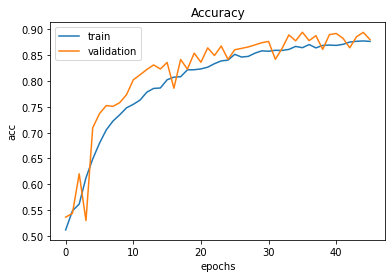

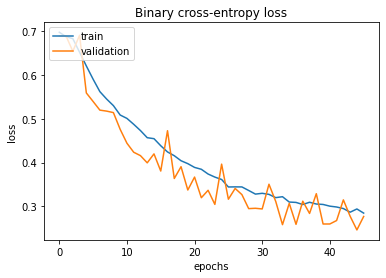

In [8]:
legend = ['train','validation']

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title("Accuracy")
plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend(legend,loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Binary cross-entropy loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(legend,loc='upper left')
plt.show()

# Save the model down

In [9]:
model.save('my_model-3_block-aug-50_epoch.h5')

# Load the model up

In [12]:
model = load_model('my_model-3_block-aug-50_epoch.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 86528)             0

# Test the accuracy after load the model

In [ ]:
print("Accuracy:",model.evaluate(valid_set))

# Extract all the conv layer to visualize the prediction
```
We take all the output of layer whose name contains 'conv' 
Then we create a new model whose outputs are those layers
```

In [13]:
layer_outputs = []
for layer in model.layers:
    if 'conv' not in(layer.name):
        continue
    layer_outputs.append(layer.output)

activation_model = Model(inputs = model.input, outputs = layer_outputs)

# Define functions
- Preprocess: Use to resize the function to the target size and map the value of pixel to [0,1]
- Predict: Create the batch and get the proabiblity of the model
- Get label: Get the label of the prediction from the probability
- Visualize: Visualize the conv layers output
- Get box: Get the best predicted box which contains the dog/cat using sliding window

In [31]:
def preprocess(img):
    img = cv2.resize(img,target)
    img = img/255
    return np.array(img)
    
def predict(img):
    img = preprocess(img)
    img = img.reshape((1,)+img.shape)
    probability = model.predict(img)
    return probability

def getLabel(probability):
    if probability<0.5:
        probability=0
    else:
        probability=1
    return list(train_set.class_indices)[probability]

def visualize(img):
    img = preprocess(img)
    img = img.reshape((1,)+img.shape)
    fmaps = activation_model.predict(img)

    for i in range(len(fmaps)):
        activation = fmaps[i]
        
        fig = plt.figure(figsize=(20,15))
        fig.suptitle(layer_outputs[i].name)
        
        for j in range(min(8*8,activation.shape[-1])):
            plt.subplot(8,8,j+1)
            plt.imshow(activation[0,:,:,j],cmap='gray')
    plt.show()

WIN_SIZES=[]
for i in range(100,260,20):
    WIN_SIZES.append(i)
    
def get_box(img,step=20,win_sizes=WIN_SIZES):
    best_box = None
    best_distance = 1
    raw_prob = predict(img)
    if (raw_prob<0.5):
        raw_prob=0
    else:
        raw_prob=1
        
    for win in win_sizes:
        print("Run with window size:",str(win))
        for top in range(0,img.shape[0]-win+1,step):
            for left in range(0,img.shape[1]-win+1,step):
                box = (left,top,left+win,top+win)
                crop = img[box[1]:box[3],box[0]:box[2]]
                prob = predict(crop)
                distance = abs(raw_prob-prob)
                if (distance<best_distance):
                    best_box = box
                    best_distance = distance
    return (best_box, best_distance)

# Testing predict with random image
```
You can change the nPic (number of picture) value to another value 
```

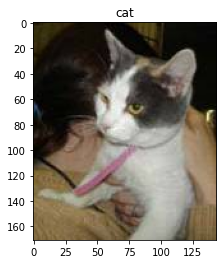

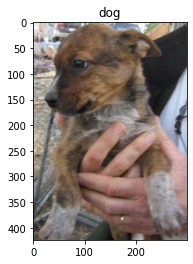

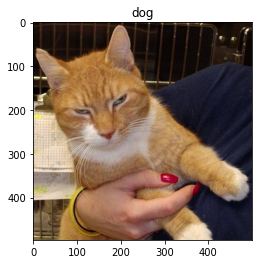

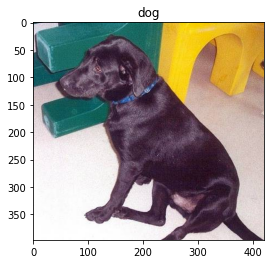

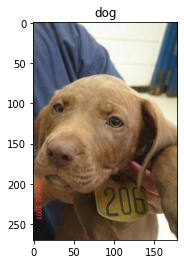

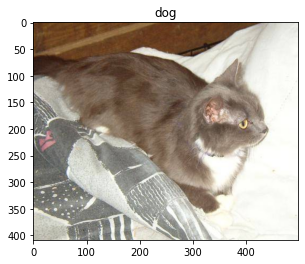

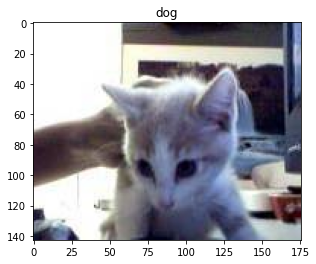

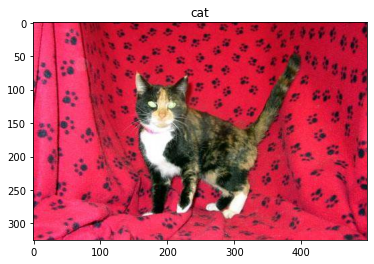

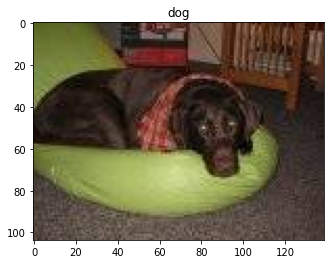

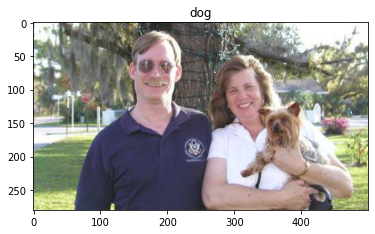

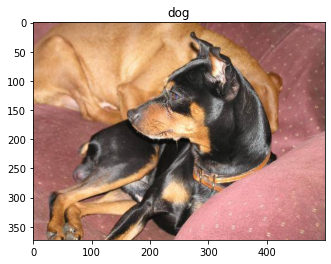

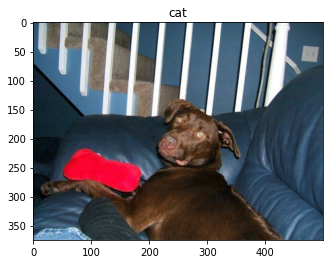

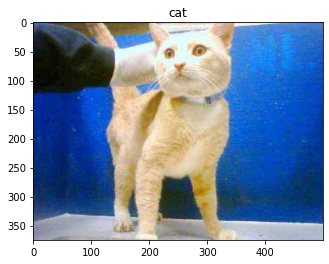

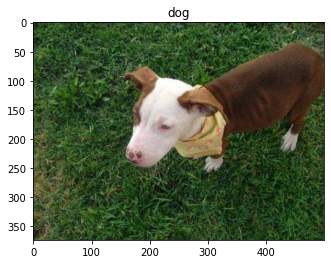

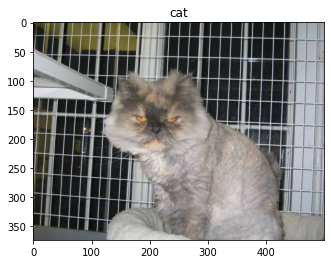

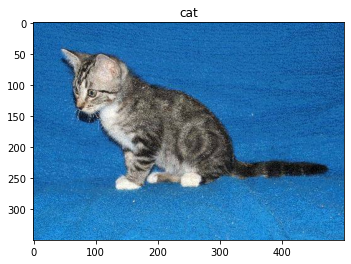

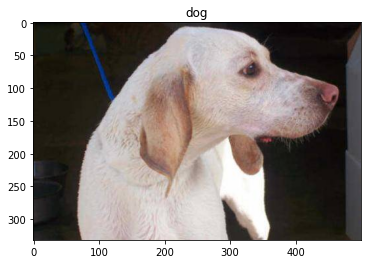

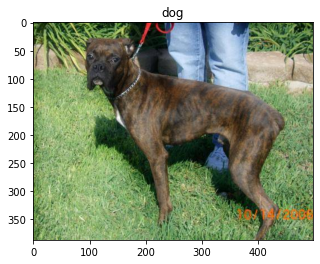

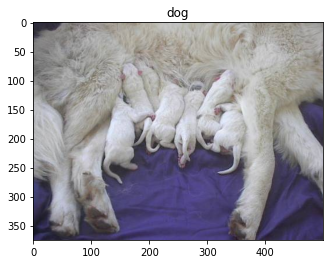

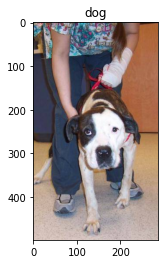

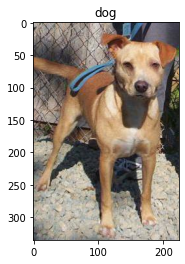

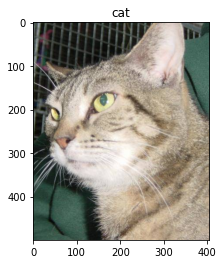

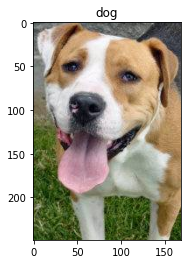

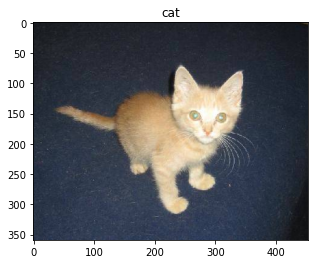

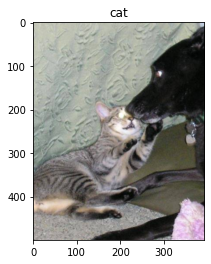

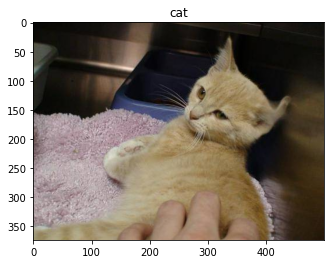

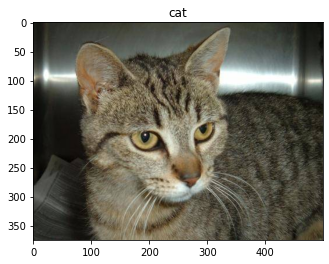

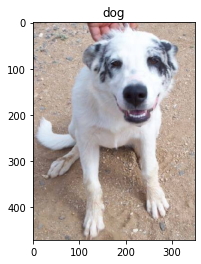

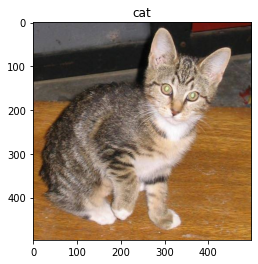

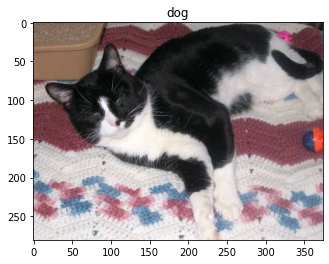

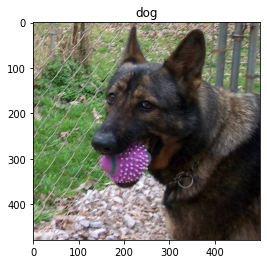

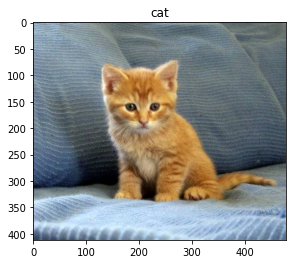

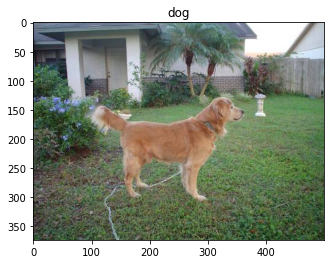

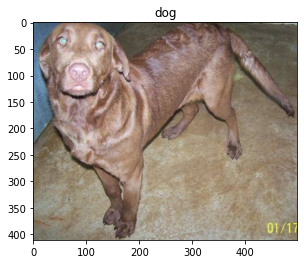

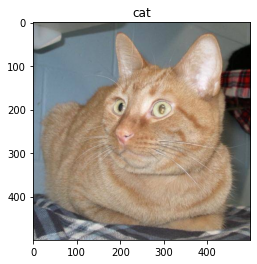

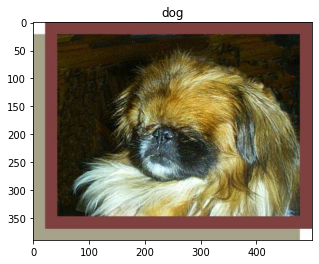

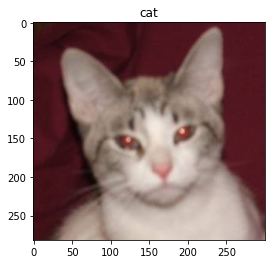

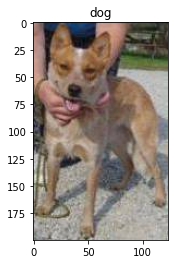

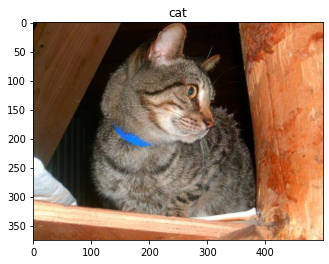

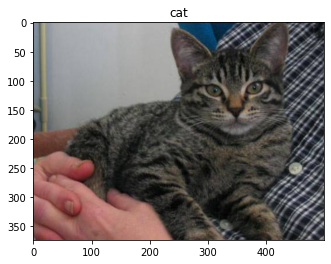

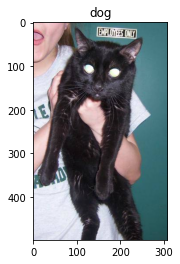

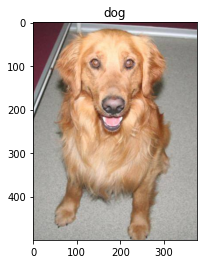

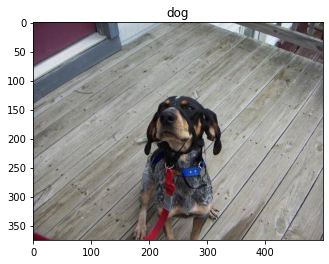

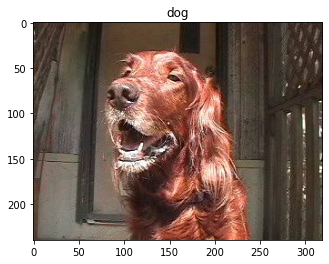

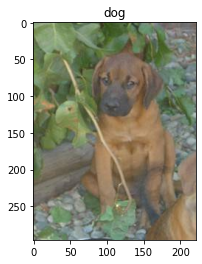

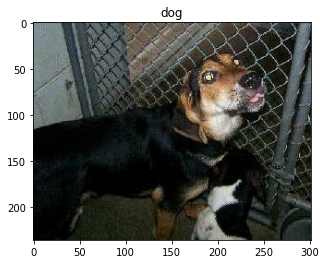

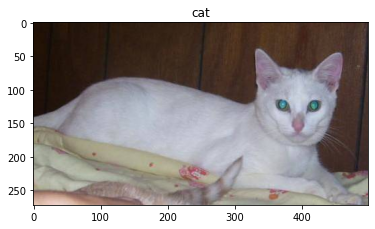

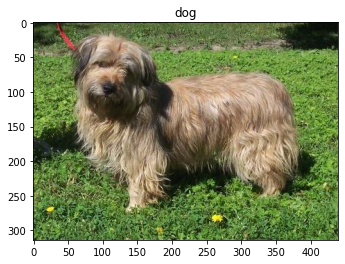

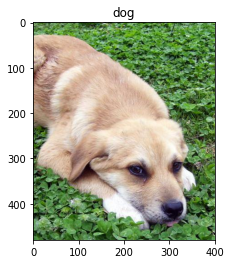

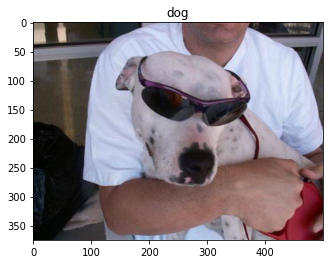

In [23]:
test_fnames = os.listdir(test_dir)
random.shuffle(test_fnames)
result = []

nPic = 50

for fnames in test_fnames:
    pred_path = os.path.join(test_dir,fnames)
    img = cv2.imread(pred_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    title = getLabel(predict(img))
    plt.imshow(img)
    plt.title(title)
    plt.show()
    
    nPic -= 1
    if (nPic==0):
        break

# Testing predict, visualize and detection with an image

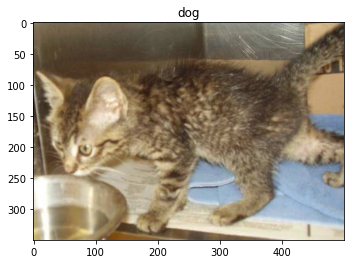

Run with window size: 100
Run with window size: 120
Run with window size: 140
Run with window size: 160
Run with window size: 180
Run with window size: 200
Run with window size: 220
Run with window size: 240
Probability: [[0.8505936]]


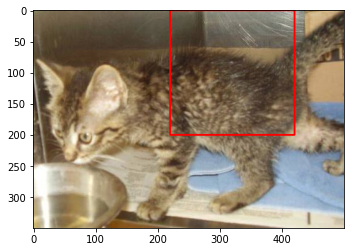

In [41]:
# Load the image
test_fnames = os.listdir(test_dir)
idPic = 0
pred_path = os.path.join(test_dir,test_fnames[idPic])
img = cv2.imread(pred_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

# Get the prediction
title = getLabel(predict(img))
        
# Plot the image and result
plt.imshow(img)
plt.title(title)
plt.show()

# Visualize the conv layers
# visualize(img)

# Finding the best fit box for detection
box, best_distance = get_box(img)
print("Probability:",1-best_distance)
startPoint = (box[0],box[1])
endPoint = (box[2],box[3])

# Draw rectangle and show image
COLOR=(255,0,0)
img = cv2.rectangle(img,startPoint,endPoint,COLOR,2)
plt.imshow(img)